<a href="https://colab.research.google.com/github/jbae99/midterm_Fall2022/blob/main/DataSciMidterm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
#installations
!pip install -U scikit-learn
!pip install pandas
#for data handling
import pandas as pd
import numpy as np
#for stats tests
import scipy as sp
#for plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
#for machine learning
from sklearn import preprocessing, model_selection, feature_selection, ensemble, linear_model, metrics, decomposition, svm, naive_bayes
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, QuantileTransformer
from sklearn.linear_model import Perceptron, ElasticNet
from sklearn.naive_bayes import GaussianNB, ComplementNB
from sklearn.svm import SVC
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.compose import make_column_selector as selector
from sklearn.calibration import CalibratedClassifierCV
from sklearn.utils import class_weight
from sklearn.gaussian_process import kernels
#for metric evaluations
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from IPython.terminal.shortcuts import newline_autoindent_outer

class MLModels:
  ##global attributes for conveinence 
  scalerTypes = {'standard':preprocessing.StandardScaler(), 'minmax':preprocessing.MinMaxScaler(), \
                 'robust':preprocessing.RobustScaler(with_centering = True, unit_variance = True), \
                 'quantileTransform':preprocessing.QuantileTransformer()}
  algorithms = {'NB':ComplementNB(), 'Perceptron':Perceptron(), 'SVM':svm.SVC()}
  __encoder = preprocessing.LabelEncoder()

  parameterDict = {"NB":{'alpha':[0, 0.1, 0.5, 1, 2, 3], 'norm':[True, False]}, \
                   "Perceptron":{'penalty':[None, 'l2', 'l1'], 'alpha':[1e-7, 1e-5, 1e-3], 'fit_intercept':[True, False], \
                'shuffle':[True, False], 'n_iter_no_change':[5, 10, 15], 'class_weight':['balanced', None]}, \
                "SVM":{'C':[ 0.5, 1, 2, 3], 'kernel':['linear', 'poly', 'rbf', 'sigmoid', 'rbf'], \
                 'degree':[1, 2, 3, 4], 'gamma':['scale', 'auto'], 'shrinking':[True, False], \
                 'class_weight':['balanced', None]}}

  ##constructor method opens, assigns, and gives a basic summary of data file given in parameter
  ##also makes a basic barplot of data 
  def __init__(self, dataPath):
    dataset = pd.read_csv(dataPath, delimiter=';',comment='#')
    self.x = dataset[['Signi070', 'Sp070', 'e_Sp070',
       'Sp070/Sbg070', 'Sconv070', 'Stot070', 'e_Stot070', 'FWHMa070',
       'FWHMb070', 'PA070', 'Signi160', 'Sp160', 'e_Sp160', 'Sp160/Sbg160',
       'Sconv160', 'Stot160', 'e_Stot160', 'FWHMa160', 'FWHMb160', 'PA160',
       'Signi250', 'Sp250', 'e_Sp250', 'Sp250/Sbg250', 'Sconv250', 'Stot250',
       'e_Stot250', 'FWHMa250', 'FWHMb250', 'PA250', 'Signi350', 'Sp350',
       'e_Sp350', 'Sp350/Sbg350', 'Sconv350', 'Stot350', 'e_Stot350',
       'FWHMa350', 'FWHMb350', 'PA350', 'Signi500', 'Sp500', 'e_Sp500',
       'Sp500/Sbg500', 'Stot500', 'e_Stot500', 'FWHMa500', 'FWHMb500', 'PA500',
       'SigniNH2', 'NpH2', 'NpH2/Nbg', 'NconvH2', 'NbgH2', 'FWHMaNH2',
       'FWHMbNH2', 'PANH2', 'NSED']]
    self.y = dataset['Coretype']
  
    print(f'Summary Stats of Loaded Dataframe \n {self.x.describe} \n {self.y.describe}')
    
    #print summary statistics of dataframe
    print(dataset.describe(include='all'))

    #make a plot (going to make better plots)
    dataset.hist(figsize=(20,20))
    
    #produce heatmap 
    pear_corr = dataset.corr(method='pearson')
    fig, ax = plt.subplots(figsize=(8,8))
    im = ax.imshow(pear_corr, interpolation='nearest')
    fig.colorbar(im, orientation='vertical', fraction = 0.05)

  ##Method preprocessces the data (might add parameters)
  def cleanData(self):
    #stripping whitespace and replacing empty values with NaN
    cat_col_sel = selector(dtype_include = object)
    for col in cat_col_sel(self.x):
      self.x[col].str.strip()
    self.x = self.x.replace(r'^\s*$', np.nan, regex=True)

    #imputing missing data (x) values
    imputer = KNNImputer(missing_values = np.nan, add_indicator = True, n_neighbors = 10)
    self.x = imputer.fit_transform(self.x)

    #encoding class (y) values
    self.y = self.__encoder.fit_transform(self.y)


  ##method splits the data into a training set and testing set based on parameter
  def splitTestTrain(self, ratio):
    #split data and print shape of train and test sets
    self.x_train, self.x_test, self.y_train, self.y_test = train_test_split(self.x, self.y, test_size = ratio)
    print(f'Shape of original Dataframe: {self.x.shape} {self.y.shape} \n\
    Shape of training data: {self.x_train.shape} {self.y_train.shape} \n\
    Shape of testing data: {self.x_test.shape} {self.y_test.shape}')

    #calculating and creating list of class weights
    self.y_weights = class_weight.compute_class_weight(class_weight = 'balanced', classes = np.unique(self.y_train), y = self.y_train)
    self.y_full_weights = []
    for value in self.y_train:
      self.y_full_weights.append(self.y_weights[value])


  ##method scales the data based on the parameter given
  def scaleData(self, scaleType):
    #Rudimentary input validation
    while scaleType not in self.scalerTypes.keys():
      scaleType = input(f'\nPlease select a valid scaler type: {self.scalerTypes.keys}')
    
    self.__scaler = self.scalerTypes[scaleType]
    #scaling x data
    print(f'Scaling test and training x data using {scaleType}')
    self.__scaler.fit(self.x_train)
    self.x_train = self.__scaler.transform(self.x_train)
    self.x_test = self.__scaler.transform(self.x_test)
    self.x_train_df = pd.DataFrame(self.x_train)
    print(f'\nSummary of dataframe scaled with {scaleType}:')
    print(self.x_train_df.describe)

  #Method utilizes Scikitlearns GridSearchCV object to construct best parameters settings for any given classification algorithm
  def findBestParams(self):

    for algo in self.algorithms.keys():
      myClassifier = self.algorithms[algo]
      myGrid = GridSearchCV(myClassifier, self.parameterDict[algo], scoring = 'accuracy')
      myGrid.fit(self.x_train, self.y_train)
      optimizedClassifier = myGrid.best_estimator_
      print(f'Optimized Parameters for {algo}: \n {optimizedClassifier.get_params}')
      print(f'Classifying Data with optimized {algo}')
      self.classifyData(optimizedClassifier)

  ##method classifies data and prints results of algorithms. Algorithm parameters accepts SciKitLearn Estimator Objects
  def classifyData(self, algorithm):

    myCalibrator = CalibratedClassifierCV(algorithm)
    myCalibrator.fit(self.x_train, self.y_train)
    self.y_pred = myCalibrator.predict(self.x_test)
    self.showResults()

    ##method analyzes predicted values generated from classifyData. Prints Confusion matrix, classification report, and overall accuracy of the algorithm
  def showResults(self):
      print(f'Confusion Matrix and full Classification Report: \n{confusion_matrix(self.y_test, self.y_pred)}')
      print(classification_report(self.y_test, self.y_pred)) 

      # Evaluate label (subsets) accuracy
      print(f'Overall Accuracy of Model: {accuracy_score(self.y_test, self.y_pred)}\n')


Summary Stats of Loaded Dataframe 
 <bound method NDFrame.describe of      Signi070    Sp070  e_Sp070  Sp070/Sbg070  Sconv070  Stot070  e_Stot070  \
0         1.6 -0.01810    0.015         -0.59   -0.0656 -0.00282      0.022   
1         0.0  0.00595    0.015          0.03    0.1070 -0.77100      0.110   
2        47.0  0.75800    0.017          3.55    0.8610  1.48000      0.038   
3         0.4 -0.00339    0.015         -0.01   -0.0338  0.28400      0.027   
4         0.0  0.00435    0.015          0.01    0.0830  4.38000      0.110   
..        ...      ...      ...           ...       ...      ...        ...   
508      48.6  0.76900    0.017          7.51    1.1900  1.18000      0.027   
509       0.0  0.00517    0.015          0.06    0.0978  0.68600      0.120   
510       0.0  0.00714    0.015          0.08    0.1310  0.72600      0.090   
511       2.9 -0.01480    0.015         -0.22   -0.2350 -0.62300      0.033   
512      39.3  0.51900    0.016          4.79    1.0700  1.28

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_data.py:2593: UserWarning: n_quantiles (1000) is greater than the total number of samples (359). n_quantiles is set to n_samples.
  "n_samples." % (self.n_quantiles, n_samples)
/usr/local/lib/python3.7/dist-packages/sklearn/naive_bayes.py:557: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  % _ALPHA_MIN
/usr/local/lib/python3.7/dist-packages/sklearn/naive_bayes.py:557: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  % _ALPHA_MIN
/usr/local/lib/python3.7/dist-packages/sklearn/naive_bayes.py:557: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  % _ALPHA_MIN
/usr/local/lib/python3.7/dist-packages/sklearn/naive_bayes.py:557: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  % _ALPHA_MIN
/usr/local/lib/python3.7/dist-packages/sklearn/naive_bayes.py:557: UserWarning: alpha too small w

Optimized Parameters for NB: 
 <bound method BaseEstimator.get_params of ComplementNB(alpha=3, norm=True)>
Classifying Data with optimized NB
Confusion Matrix and full Classification Report: 
[[30  0 16]
 [ 5  5  6]
 [ 9  0 83]]
              precision    recall  f1-score   support

           0       0.68      0.65      0.67        46
           1       1.00      0.31      0.48        16
           2       0.79      0.90      0.84        92

    accuracy                           0.77       154
   macro avg       0.82      0.62      0.66       154
weighted avg       0.78      0.77      0.75       154

Overall Accuracy of Model: 0.7662337662337663

Optimized Parameters for Perceptron: 
 <bound method BaseEstimator.get_params of Perceptron(alpha=1e-05, class_weight='balanced', fit_intercept=False,
           n_iter_no_change=10, penalty='l1')>
Classifying Data with optimized Perceptron
Confusion Matrix and full Classification Report: 
[[33  0 13]
 [ 5  4  7]
 [ 7  2 83]]
              p

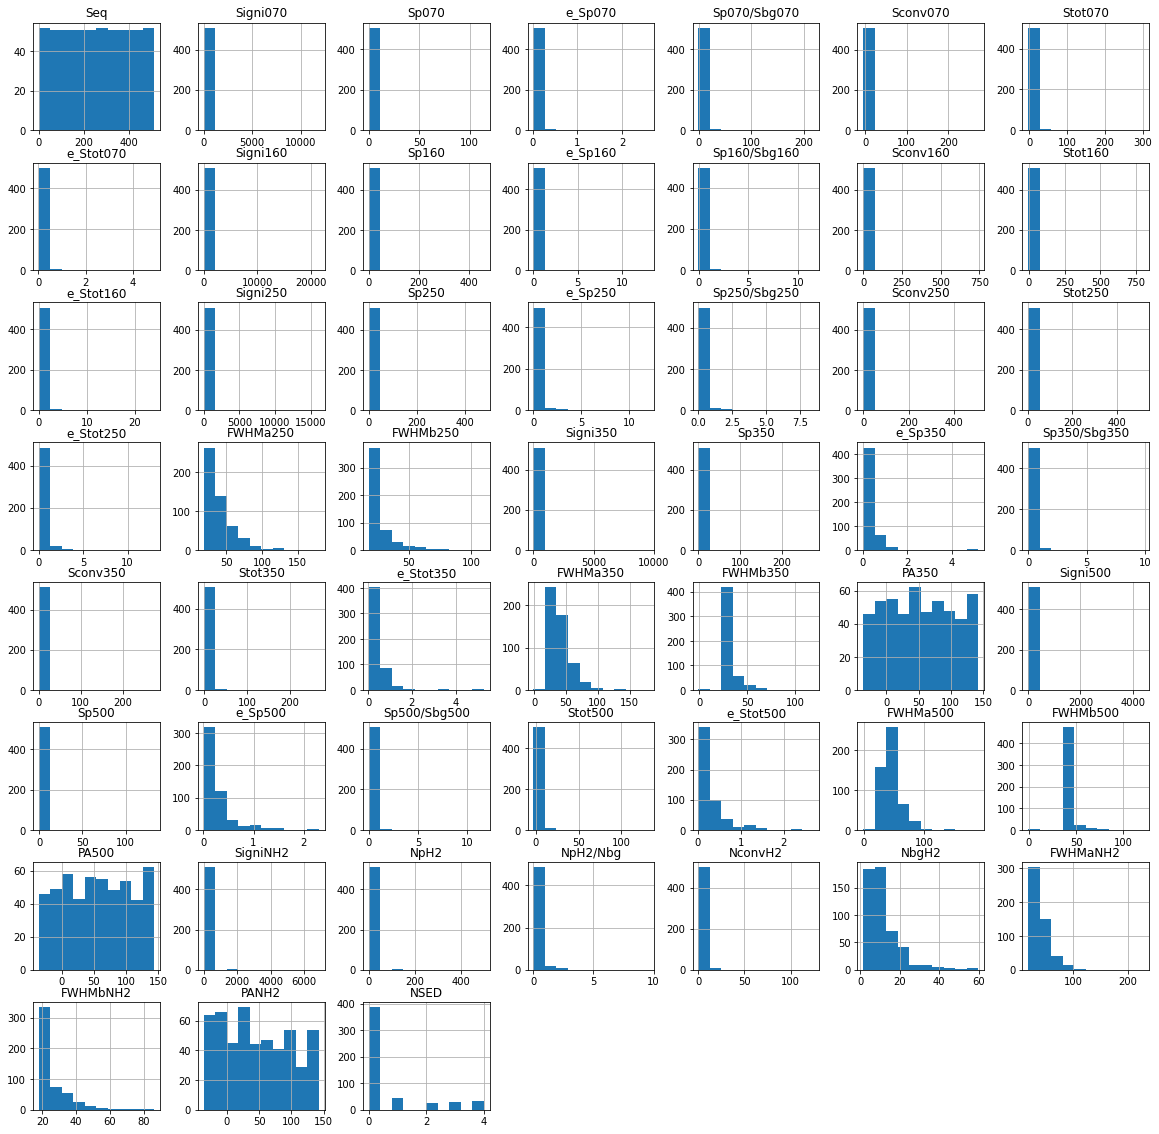

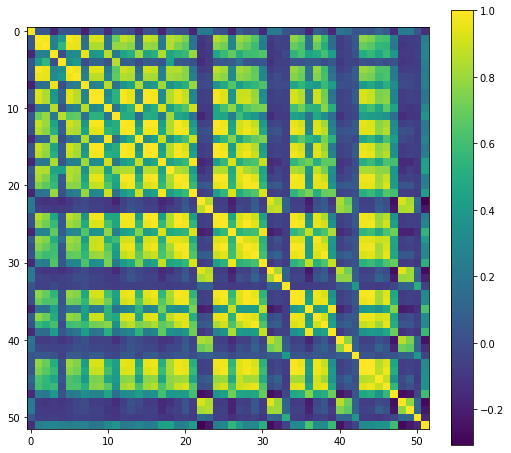

In [ ]:
dataPath = '/content/gdrive/MyDrive/Topics Data/ophiuchus_tablea1(1).tsv'


##Create a MLModels object (loads the data from dataPath, splits x and y, and gives basic summary)
myMachine = MLModels(dataPath)

myMachine.cleanData()

##split the data into training and testing
myMachine.splitTestTrain(0.3)

##scale the data (possible inputs are 'standard', 'minmax', and 'robust' (all found in myMachine.scaleTypes))
myMachine.scaleData('quantileTransform')

myMachine.findBestParams()



